# Self-supervised contrastive learning with SimSiam

This notebook shows how to use Self-supervised non-contrastive learning with SimSiam and various data augmentations. This notebook makes use of the given bounding boxes from WENN as well as the same bounding boxes on the images taken before and after the image. The image extraction can be done with the cut_out_and_reparse_for_selfsupervised.ipynb in notebooks/preprocessing/other folder.

## Setup and loading car images

In [1]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import cv2

import pathlib
from pathlib import Path
import json
import mlflow
from simple_siamese import get_encoder, get_predictor, SimSiam, train_test_split_array

2022-08-25 15:24:16.651959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-25 15:24:16.652091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [2]:
# Enable auto-logging to MLflow to capture TensorBoard and Keras metrics.
mlflow.tensorflow.autolog()
mlflow.keras.autolog()

2022/08/25 15:24:18 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
/Users/melinasoysal/miniforge3/envs/tensorflow-vscode/lib/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py:416: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)


In [3]:
EXPERIMENT1 = "Backbone"
existing_backbone_ID = mlflow.get_experiment_by_name(EXPERIMENT1)
if not existing_backbone_ID:
    EXPERIMENT_ID_Backbone = mlflow.create_experiment(EXPERIMENT1)
EXP1 = mlflow.set_experiment(EXPERIMENT1)

EXPERIMENT2 = "FinalClassifier"
existing_final_ID = mlflow.get_experiment_by_name(EXPERIMENT2)
if not existing_final_ID:
    EXPERIMENT_ID_Final = mlflow.create_experiment(EXPERIMENT2)
EXP2 = mlflow.set_experiment(EXPERIMENT2)

In [4]:
#Define Hyperparameters

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 20
CROP_TO = 80
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 4
WEIGHT_DECAY = 0.0005

In [5]:
with Path(r"../../preprocessing/other/restructured.json"
         ).open() as f:
    data = json.load(f)

annotations = data['annotations']

image_label_dict = {}
for annotate in annotations:
    image_label_dict[annotate['id']] = annotate['category_id']
#print(image_label_dict)


In [6]:
#inspect data folder
data_dir = r"../../../data/cropped/"
data_dir = pathlib.Path(data_dir)
#print(data_dir)
images = []
labels = []
for file in data_dir.glob('*.png'):
    image_id = int(str(file).split('/')[-1].split('.')[0])
    #print(image_id)
    if image_id in image_label_dict:
        im = cv2.imread(str(file))
        im = cv2.resize(im, (CROP_TO, CROP_TO))
        images.append(im)
        labels.append(image_label_dict[image_id])
        #print(image_label_dict[image_id])

images = np.stack(images, axis=0)
labels = np.stack(labels, axis=0)
print(images.shape)
print(labels.shape)

(897, 80, 80, 3)
(897,)


## Setting up the data augmentation pipeline

In [7]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image


def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

## Convert the data into TensorFlow Dataset objects

2022-08-25 15:24:26.176341: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


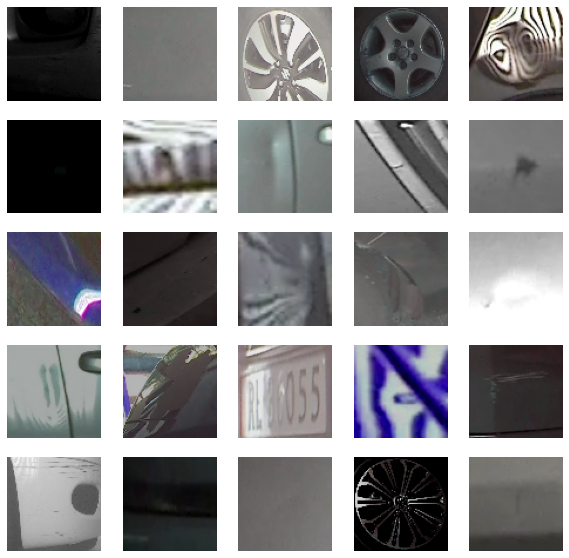

--------


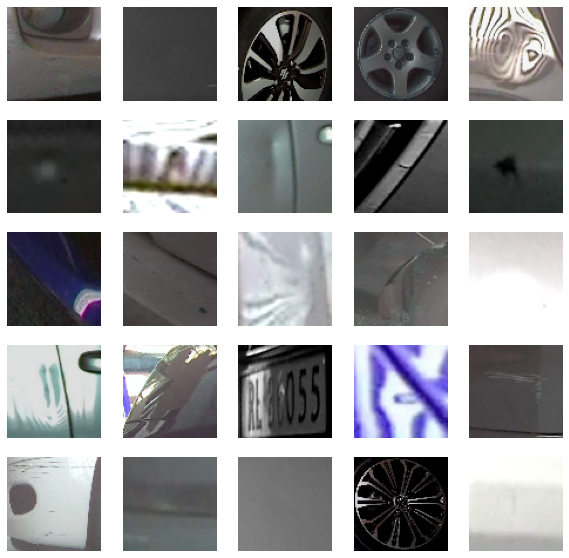

In [8]:
#dataset 1
ssl_ds_one = tf.data.Dataset.from_tensor_slices(images)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

#dataset 2
ssl_ds_two = tf.data.Dataset.from_tensor_slices(images)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

print('--------')

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

2022/08/25 15:24:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.


Epoch 1/20


2022-08-25 15:24:31.538490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 33s 3s/step - loss: -0.6987
Epoch 2/20
8/8 [==============================] - 23s 3s/step - loss: -0.8597
Epoch 3/20
8/8 [==============================] - 23s 3s/step - loss: -0.8785
Epoch 4/20
8/8 [==============================] - 23s 3s/step - loss: -0.8874
Epoch 5/20
8/8 [==============================] - 23s 3s/step - loss: -0.8957
Epoch 6/20
8/8 [==============================] - 23s 3s/step - loss: -0.8765
Epoch 7/20
8/8 [==============================] - 23s 3s/step - loss: -0.9030
Epoch 8/20
8/8 [==============================] - 23s 3s/step - loss: -0.8787
Epoch 9/20
8/8 [==============================] - 23s 3s/step - loss: -0.8897
Epoch 10/20
8/8 [==============================] - 23s 3s/step - loss: -0.8967
Epoch 11/20
8/8 [==============================] - 22s 3s/step - loss: -0.8968
Epoch 12/20
8/8 [==============================] - 23s 3s/step - loss: -0.9006


2022/08/25 15:29:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Model <simple_siamese.SimSiam object at 0x2ca9a54c0> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.


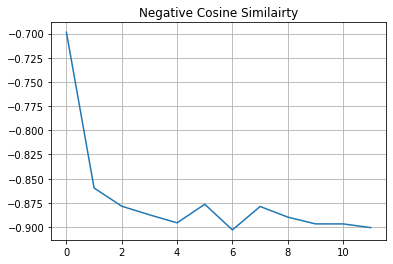

In [9]:
run_name = str(BATCH_SIZE) + '_' + str(EPOCHS) + '_' + str(CROP_TO) + '_' + str(SEED) + '_' + str(
    PROJECT_DIM) + '_' + str(LATENT_DIM) + '_' + str(WEIGHT_DECAY)
with mlflow.start_run(experiment_id=EXP1.experiment_id) as run1:
    BACKBONE_ID = run1.info.run_id
    mlflow.log_metric('batch_size', BATCH_SIZE)
    mlflow.log_metric('PROJECT_DIM', PROJECT_DIM)
    mlflow.log_param('CROP_TO', CROP_TO)
    mlflow.log_param('SEED', SEED)
    mlflow.log_param('LATENT_DIM', LATENT_DIM)
    mlflow.log_param('WEIGHT_DECAY', WEIGHT_DECAY)
    mlflow.log_param('mode', 'only cropped')
    # Create a cosine decay learning scheduler.
    num_training_samples = len(images)
    steps = EPOCHS * (num_training_samples // BATCH_SIZE)
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.03,
                                                            decay_steps=steps)

    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                    patience=5,
                                                    restore_best_weights=True)

    # Compile model and start training.
    simsiam = SimSiam(get_encoder(), get_predictor())
    simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
    history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
#Trained SimSiam
n_neighbors = [2, 3, 4, 5]
TRAIN_TEST_SPLIT = [0.1, 0.2, 0.3, 0.5, 0.8, 0.85, 0.9, 0.95]

for n in n_neighbors:
    for t in TRAIN_TEST_SPLIT:
        with mlflow.start_run(experiment_id=EXP2.experiment_id):
            train_images, test_images, train_labels, test_labels = train_test_split_array(
                images, labels, t)
            backbone = tf.keras.Model(simsiam.encoder.input,
                                      simsiam.encoder.get_layer("backbone_pool").output)
            train_backbone = backbone(train_images)
            test_backbone = backbone(test_images)
            mlflow.log_param('BACKBONE_ID', BACKBONE_ID)
            mlflow.log_param('TRAIN_TEST_SPLIT', t)
            mlflow.log_param('n_neighbors', n)
            mlflow.log_param('mode', 'only cropped')
            neigh = KNeighborsClassifier(n_neighbors=n)
            neigh.fit(train_backbone, train_labels)
            test_acc = neigh.score(test_backbone, test_labels)
            print("Test accuracy: {:.2f}%".format(test_acc * 100))
            mlflow.log_param('test_acc', test_acc)
            predict_labels = neigh.predict(test_backbone)
            confusion_matrix_result = confusion_matrix(test_labels, predict_labels)
            mlflow.log_param('confusion_matrix', confusion_matrix_result)
            recall_micro = recall_score(test_labels, predict_labels, average = 'micro')
            mlflow.log_param('recall_micro', recall_micro)
            recall_macro = recall_score(test_labels, predict_labels, average='macro')
            mlflow.log_param('recall_macro', recall_macro)
            precision = precision_score(test_labels, predict_labels, average='micro')
            mlflow.log_param('precision', precision)


Test accuracy: 43.69%
Test accuracy: 45.26%
Test accuracy: 47.61%
Test accuracy: 49.67%
Test accuracy: 46.11%
Test accuracy: 45.19%
Test accuracy: 45.56%
Test accuracy: 37.78%
Test accuracy: 42.08%
Test accuracy: 44.57%
Test accuracy: 46.02%
Test accuracy: 48.55%
Test accuracy: 55.00%
Test accuracy: 55.56%
Test accuracy: 55.56%
Test accuracy: 53.33%
Test accuracy: 42.82%
Test accuracy: 46.80%
Test accuracy: 47.93%
Test accuracy: 50.33%
Test accuracy: 51.11%
Test accuracy: 50.37%
Test accuracy: 52.22%
Test accuracy: 48.89%
Test accuracy: 46.04%
Test accuracy: 46.94%
Test accuracy: 47.77%
Test accuracy: 49.89%
Test accuracy: 53.89%
Test accuracy: 54.81%
Test accuracy: 53.33%
Test accuracy: 51.11%


/Users/melinasoysal/miniforge3/envs/tensorflow-vscode/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/melinasoysal/miniforge3/envs/tensorflow-vscode/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(<AxesSubplot:xlabel='tsne-1', ylabel='tsne-2'>,)

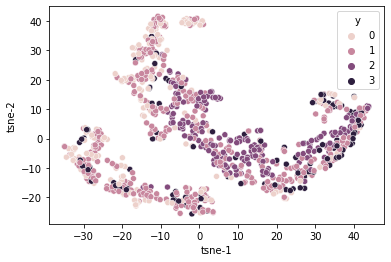

In [12]:
#plot t-Distributed Stochastic Neighbour Embedding
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
representation = TSNE().fit_transform(train_backbone)
df_tsne = pd.DataFrame({
    "y": train_labels,
    "tsne-1": representation[:, 0],
    "tsne-2": representation[:, 1]
})
sns.scatterplot(data=df_tsne, hue="y", x="tsne-1", y="tsne-2"),


In [15]:
from sklearn.neighbors import KNeighborsClassifier
import resnet_cifar

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1
#only ResNet Backbone, no SimSiam
n_neighbors = [2, 3, 4, 5]
TRAIN_TEST_SPLIT = [0.1, 0.5, 0.9]

for n in n_neighbors:
    for t in TRAIN_TEST_SPLIT:
        with mlflow.start_run(experiment_id=EXP2.experiment_id):
            train_images, test_images, train_labels, test_labels = train_test_split_array(
                images, labels, t)

            x_train = resnet_cifar.stem(train_images.astype(np.float32) / 255.)
            x_train = resnet_cifar.learner(x_train, NUM_BLOCKS)
            x_train = tf.keras.layers.Flatten()(x_train)

            x_test = resnet_cifar.stem(test_images.astype(np.float32) / 255.)
            x_test = resnet_cifar.learner(x_test, NUM_BLOCKS)
            x_test = tf.keras.layers.Flatten()(x_test)

            mlflow.log_param('BACKBONE_ID', 'onlyResNet')
            mlflow.log_param('TRAIN_TEST_SPLIT', t)
            mlflow.log_param('n_neighbors', n)
            mlflow.log_param('mode', 'only cropped')
            neigh = KNeighborsClassifier(n_neighbors=n)
            neigh.fit(x_train.numpy(), train_labels)
            test_acc = neigh.score(x_test.numpy(), test_labels)
            print("Test accuracy: {:.2f}%".format(test_acc * 100))
            mlflow.log_param('test_acc', test_acc)
            predict_labels = neigh.predict(x_test.numpy())
            confusion_matrix_result = confusion_matrix(test_labels, predict_labels)
            mlflow.log_param('confusion_matrix', confusion_matrix_result)
            recall_micro = recall_score(test_labels, predict_labels, average='micro')
            mlflow.log_param('recall_micro', recall_micro)
            recall_macro = recall_score(test_labels, predict_labels, average='macro')
            mlflow.log_param('recall_macro', recall_macro)
            precision = precision_score(test_labels, predict_labels, average='micro')
            mlflow.log_param('precision', precision)


Test accuracy: 41.09%
Test accuracy: 36.97%
Test accuracy: 34.44%
Test accuracy: 39.60%
Test accuracy: 39.42%
Test accuracy: 43.33%
Test accuracy: 40.84%
Test accuracy: 39.64%
Test accuracy: 36.67%
Test accuracy: 41.83%
Test accuracy: 38.53%
Test accuracy: 44.44%
